In [1]:
import torch
import geoopt
import ot

import numpy as np
import matplotlib.pyplot as plt
import torch.distributions as D
import sys
sys.path.insert(0, "/root/spdtsw/Sliced-Wasserstein_Distances_and_Flows_on_Cartan-Hadamard_Manifolds")
from pyriemann.datasets import sample_gaussian_spd, generate_random_spd_matrix

from torch.utils.data import DataLoader
from itertools import cycle

from hswfs_new.chswf import chswf, chtswf
from hswfs_new.manifold.spd import LogEuclidean, SPD_Euclidean

/root/miniconda3/envs/spdtsw_gr/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"

### Utils Plot

In [3]:
from matplotlib.collections import LineCollection
from matplotlib.colors import LinearSegmentedColormap
from mpl_toolkits.mplot3d.art3d import Line3DCollection


cdict1 = {'red':   ((0.0, 0.0, 0.0),
                    (0.5, 0.0, 0.1),
                    (1.0, 1.0, 1.0)),

         'green': ((0.0, 0.0, 0.0),
                   (1.0, 0.0, 0.0)),

         'blue':  ((0.0, 0.0, 1.0),
                   (0.5, 0.1, 0.0),
                   (1.0, 0.0, 0.0))
         }

blue_red1 = LinearSegmentedColormap('BlueRed1', cdict1, N=256)



def plot_trajectory(particles, colorbar=False, ax=None, fig=None, log=False):
    x0 = particles[0]
    
    if ax is None:
#         fig, ax = plt.subplots(1,1, figsize=(10,10))
        fig = plt.figure(figsize=(10,10)) #figsize=plt.figaspect(1))  # Square figure
        ax = fig.add_subplot(111, projection='3d')

    ts = np.arange(len(particles))
    if log:
        ts[0] = 1
        ts = np.log(ts)
    
    for k in range(x0.shape[0]):
        segments = [np.stack([particles[i:i+2,k,0,0], particles[i:i+2,k,1,1], particles[i:i+2,k,0,1]], axis=-1) for i in range(len(particles))]
                
            
        lc = Line3DCollection(segments, cmap=blue_red1, array=ts, linewidths=0.5)
        line = ax.add_collection(lc)
        

    if colorbar:
        cb = fig.colorbar(line, ax=ax)
        
#     ax.set_yticklabels([])
#     ax.set_xticklabels([])
#     ax.set_xticks([])
#     ax.set_yticks([])

    ax.scatter(x0[:,0,0], x0[:,1,1], x0[:,0,1], label="Initial particles", c="blue", s=1)
    ax.scatter(particles[-1][:,0,0], particles[-1][:,1,1], particles[-1][:,0,1], label="Final particles", c="red", s=1)
    
#     ax.set_xlim(-3, 7)
#     ax.set_ylim(-3, 7)
#     plt.axis("equal")
#     ax.axis("off")

    return line

### Data

In [4]:
n = 50

mean_target = generate_random_spd_matrix(2)
sigma_target = 0.1

X_target = torch.tensor(sample_gaussian_spd(n_matrices=1000, mean=mean_target, sigma=sigma_target), device=device)

train_dl = DataLoader(X_target, batch_size=n, shuffle=True)
dataiter = iter(cycle(train_dl))

### SPDSWFs

In [ ]:
manifold_spd = geoopt.SymmetricPositiveDefinite()
x0 = manifold_spd.random((n,2,2)).to(device).type(torch.float64)

manifold = SPD_Euclidean(d=2)

L = chtswf(x0, 1, dataiter, manifold)

distance_based


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]


torch.Size([10, 5, 2, 2])
d_potential[:, :, None] shape torch.Size([10, 5, 100])
nabla_prj shape: torch.Size([10, 5, 1, 4])


RuntimeError: einsum(): the number of subscripts in the equation (3) does not match the number of dimensions (0) for operand 1 and no ellipsis was given

/root/miniconda3/envs/spdtsw_gr/lib/python3.9/site-packages/ot/lp/__init__.py:630: UserWarning: Problem infeasible. Check that a and b are in the simplex
  check_result(result_code)
/root/miniconda3/envs/spdtsw_gr/lib/python3.9/site-packages/ot/lp/__init__.py:630: UserWarning: Problem unbounded
  check_result(result_code)


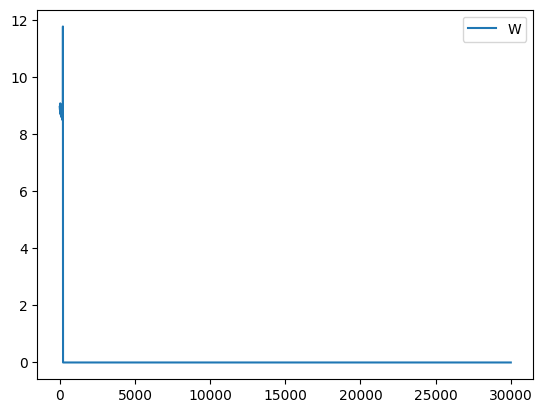

In [8]:
L_w_sw = []

for x in L:
    target = next(dataiter).detach().to(device)
        
    a = torch.ones((n,), device=device)/n
    b = torch.ones((len(target),), device=device)/len(target)
    
    M = manifold_spd.dist(x[:,None].to('cuda'), target[None].to('cuda'))**2

    w = ot.emd2(a, b, M)
    L_w_sw.append(w.item())


plt.plot(L_w_sw, label="W")
plt.legend()
plt.show()

/tmp/ipykernel_3902812/2182912725.py:1: RuntimeWarning: divide by zero encountered in log10
  plt.plot(np.log10(np.array(L_w_sw)))


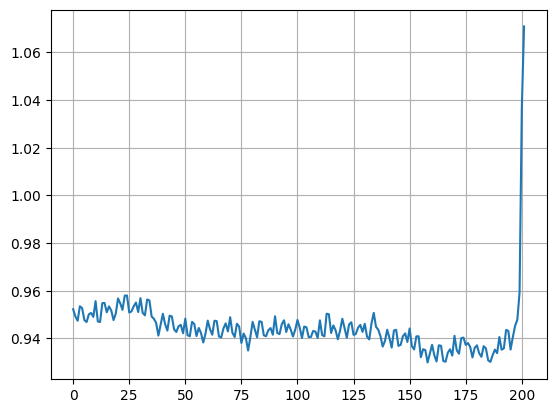

In [9]:
plt.plot(np.log10(np.array(L_w_sw)))
plt.grid(True)
plt.show()

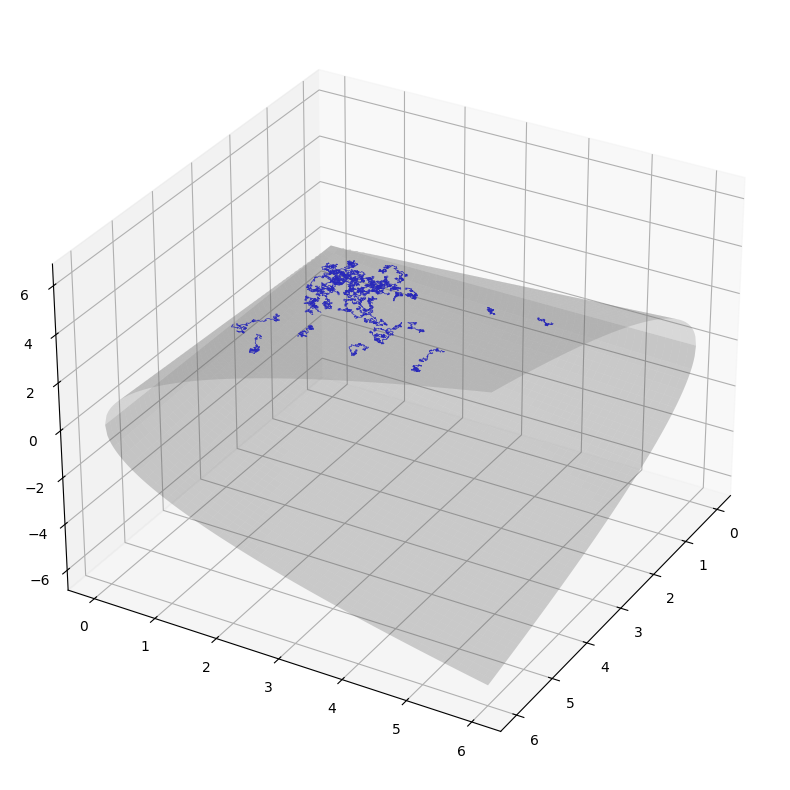

In [10]:
fig = plt.figure(figsize=(10,10)) #figsize=plt.figaspect(1))  # Square figure
ax = fig.add_subplot(111, projection='3d')

plot_trajectory(np.array([L[k].numpy() for k in range(len(L))]), ax=ax)
ax.view_init(roll=0, azim=30)

## Plot Cone
maxi = 6

x = np.linspace(0, maxi, 201)
y = np.linspace(0, maxi, 201)
[x,y] = np.meshgrid(x, y)
z = np.sqrt(x*y)
ax.plot_surface(x, y, z,  rstride=4, cstride=4, color='gray', alpha=0.25)

z = -np.sqrt(x*y)
ax.plot_surface(x, y, z,  rstride=4, cstride=4, color='gray', alpha=0.25)

plt.show()

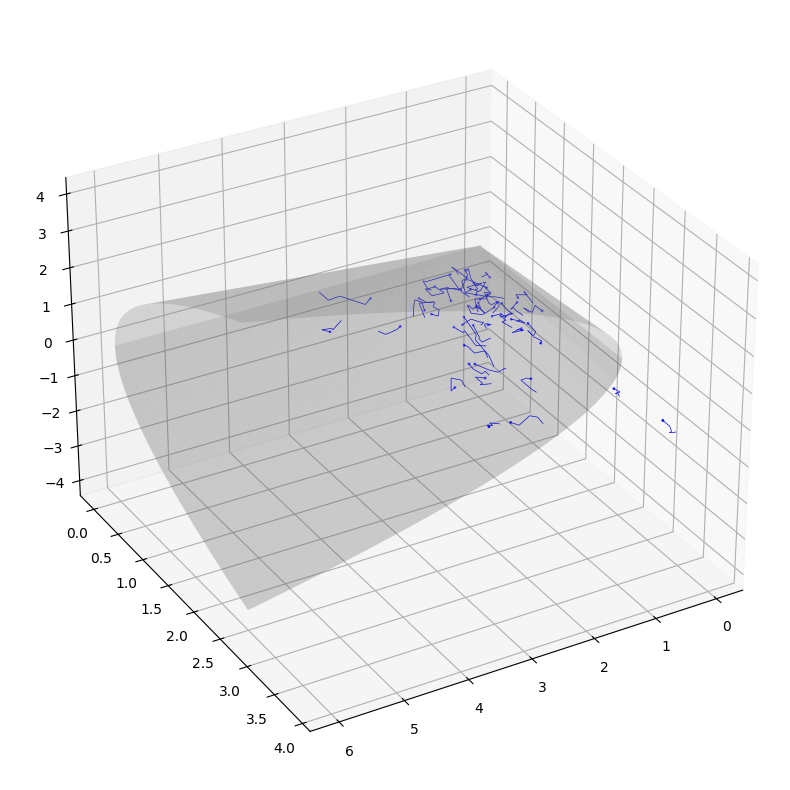

In [11]:
fig = plt.figure(figsize=(10,10)) #figsize=plt.figaspect(1))  # Square figure
ax = fig.add_subplot(111, projection='3d')

plot_trajectory(np.array([L[k].numpy() for k in range(0, len(L), 50)]), ax=ax)
ax.view_init(roll=0, azim=60)

## Plot Cone
x = np.linspace(0, 6, 201)
y = np.linspace(0, 2.5, 201)
[x,y] = np.meshgrid(x, y)
z = np.sqrt(x*y)
ax.plot_surface(x, y, z,  rstride=4, cstride=4, color='gray', alpha=0.25)

z = -np.sqrt(x*y)
ax.plot_surface(x, y, z,  rstride=4, cstride=4, color='gray', alpha=0.25)

plt.show()

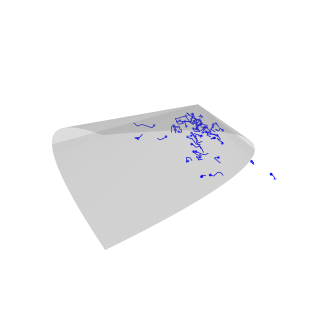

In [12]:
fig = plt.figure(figsize=(6, 4)) #figsize=plt.figaspect(1))  # Square figure
ax = fig.add_subplot(111, projection='3d')

plot_trajectory(np.array([L[k].numpy() for k in range(0,len(L), 50)]), ax=ax)
ax.view_init(roll=0, azim=60)

## Plot Cone
x = np.linspace(0, 6, 201)
y = np.linspace(0, 2.5, 201)
[x,y] = np.meshgrid(x, y)
z = np.sqrt(x*y)
ax.plot_surface(x, y, z,  rstride=4, cstride=4, color='gray', alpha=0.25)

z = -np.sqrt(x*y)
ax.plot_surface(x, y, z,  rstride=4, cstride=4, color='gray', alpha=0.25)

plt.axis(False)

plt.savefig("./Evolution_trajectory_SPD.pdf", format="pdf", bbox_inches="tight")

plt.show()

In [13]:
np.save("./Trajectories.npy", L, allow_pickle=True)

In [14]:
test = np.load("./Trajectories.npy", allow_pickle=True)

### SWFs

In [15]:
manifold = SPD_Euclidean(d=2)

L2 = chswf(x0, 1001, dataiter, manifold, tauk=1e-1, n_projs=100)

100%|██████████| 1001/1001 [00:14<00:00, 68.88it/s]


/root/miniconda3/envs/spdtsw_gr/lib/python3.9/site-packages/ot/lp/__init__.py:630: UserWarning: Problem infeasible. Check that a and b are in the simplex
  check_result(result_code)


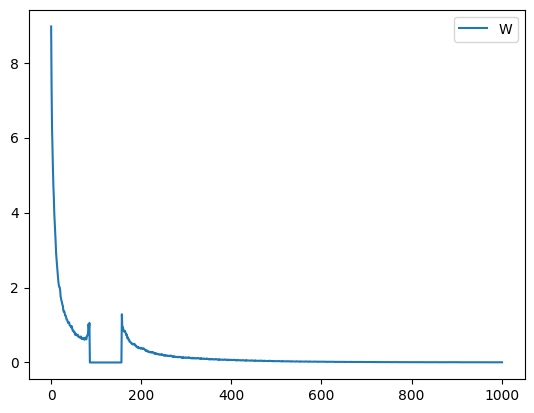

In [17]:
L_w_sw = []

for x in L2:
    target = next(dataiter).detach().to(device)
        
    a = torch.ones((n,), device=device)/n
    b = torch.ones((n,), device=device)/n
    
    M = manifold_spd.dist(x[:,None].to('cuda'), target[None].to('cuda'))**2

    w = ot.emd2(a, b, M)
    L_w_sw.append(w.item())


plt.plot(L_w_sw, label="W")
plt.legend()
plt.show()

/tmp/ipykernel_3902812/2182912725.py:1: RuntimeWarning: divide by zero encountered in log10
  plt.plot(np.log10(np.array(L_w_sw)))


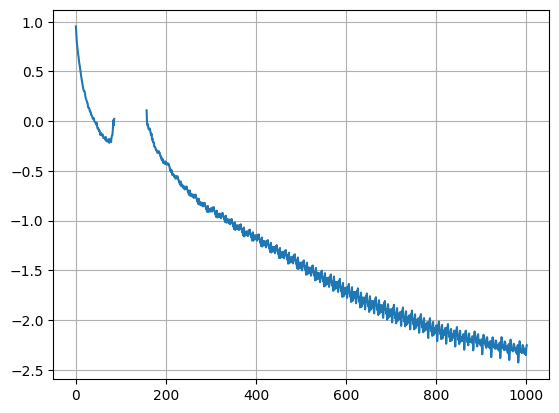

In [18]:
plt.plot(np.log10(np.array(L_w_sw)))
plt.grid(True)
plt.show()

In [19]:
torch.any(torch.linalg.det(torch.cat(L2, axis=0))<0)

tensor(True)